# PART 3c - BERT + BLSTM DEEP LEARNING MODEL WITH FINETUNING 

The code formatting below has been borrowed and adapted from Keras - https://keras.io/examples/nlp/semantic_similarity_with_bert/


In [1]:
"""
## Setup
Note: install HuggingFace `transformers` via `pip install transformers` (version >= 2.11.0).
"""
!pip install transformers==2.11.0

import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

     |████████████████████████████████| 674 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 37.2 MB/s 
     |████████████████████████████████| 1.2 MB 25.0 MB/s 
     |████████████████████████████████| 5.6 MB 11.7 MB/s 


In [28]:
"""
## Configuration
"""

max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 3

# Labels in our dataset.
labels = ["Non-contradiction", "Contradiction"]

In [3]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  7094k      0  0:00:01  0:00:01 --:--:-- 7089k
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [ ]:
# There are more than 550k samples in total; use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

In [5]:
# Drope NaN entries in our train data
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64


In [6]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       33384
contradiction    33310
neutral          33193
-                  110
Name: similarity, dtype: int64


In [7]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


In [8]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [9]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 1 if x == "contradiction" else 0 
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=2)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 1 if x == "contradiction" else 0 
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=2)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 1 if x == "contradiction" else 0 
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=2)

In [10]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


In [11]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased", output_hidden_states=False)
    base_output = bert_model.bert([input_ids, attention_masks, token_type_ids])
    seq_out, _ = base_output[0], base_output[1]
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    sequence_output, pooled_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f153c7f7450>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
___________________________

In [12]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
3121/3121 [==============================] - 2001s 634ms/step - loss: 0.4104 - acc: 0.8179 - val_loss: 0.3221 - val_acc: 0.8646
Epoch 2/2
3121/3121 [=

In [14]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

312/312 [==============================] - 164s 523ms/step - loss: 0.3015 - acc: 0.8776


[0.30153822898864746, 0.8776041865348816]

In [15]:
# Load dataset
from google.colab import files
uploaded = files.upload()

Saving sar_df.csv to sar_df.csv


In [16]:
import io
sar_df = pd.read_csv(io.BytesIO(uploaded['sar_df.csv']), index_col=0)

In [17]:
df = sar_df.sample(frac = 1, random_state = 0)


In [18]:
data = df[["new_comment_lemm","new_pcomment_lemm" ]]
labels = df['label']

In [19]:
from sklearn.model_selection import train_test_split

X, new_test_df, y, new_y_test = train_test_split(data,labels,test_size=0.2,train_size=0.8)
new_train_df, new_valid_df, new_y_train, new_y_val = train_test_split(X,y,test_size = 0.16,train_size =0.84)

In [20]:
new_train_df.shape, new_test_df.shape

((100800, 2), (30000, 2))

In [21]:
new_train_df

,new_comment_lemm,new_pcomment_lemm
266422,you ll know because you ll be ban,how do I know when a wave be on
50797,speak out and you ll be silence in the new regime,why for point out that td be fill with horribl...
45395,be t too late to adopt yourself out to a new f...,thank its really hard because I love my parent...
781992,not with the hold action sigh,compatible with quickactivator
495406,so do I she a godawful artist,I do nt even know that be suppose to be a man ...
...,...,...
940867,or next year thank dog,rick santorum will not be president this year
999916,sound like conspiracy theory bullshit to I,australian climate scientist the murdoch mediu...
409326,yo goy your boring biased repetitive anti jew ...,but always remember goy white people gangrape ...
192328,sweet dose of nationalism to the uneducated guard,on camera minister mahesh sharma staff slap gu...


In [22]:
new_y_train

266422    1
50797     1
45395     1
781992    0
495406    0
         ..
940867    0
999916    1
409326    1
192328    1
988588    0
Name: label, Length: 100800, dtype: int64

In [23]:
new_train_df = new_train_df.reset_index(drop=True)

new_valid_df = new_valid_df.reset_index(drop=True)


In [24]:
new_y_train = tf.keras.utils.to_categorical(new_y_train.values, num_classes=2)
new_y_val = tf.keras.utils.to_categorical(new_y_val.values, num_classes=2)
new_y_test = tf.keras.utils.to_categorical(new_y_test.values, num_classes=2)

In [25]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]        

In [26]:
new_train_data = BertSemanticDataGenerator(
    new_train_df[["new_comment_lemm", "new_pcomment_lemm"]].values.astype("str"),
    new_y_train,
    batch_size=batch_size,
    shuffle=True,
)
new_valid_data = BertSemanticDataGenerator(
    new_valid_df[["new_comment_lemm", "new_pcomment_lemm"]].values.astype("str"),
    new_y_val,
    batch_size=batch_size,
    shuffle=False,
)

In [29]:
history = model.fit(
    new_train_data,
    validation_data=new_valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/3
3150/3150 [==============================] - 5088s 2s/step - loss: 0.5850 - accuracy: 0.6868 - val_loss: 0.5348 - val_accuracy: 0.7250
Epoch 2/3
3150/3150 [==============================] - 5085s 2s/step - loss: 0.5040 - accuracy: 0.7528 - val_loss: 0.5241 - val_accuracy: 0.7373
Epoch 3/3
3150/3150 [==============================] - 5081s 2s/step - loss: 0.4253 - accuracy: 0.8035 - val_loss: 0.5373 - val_accuracy: 0.7417


In [30]:
new_test_data = BertSemanticDataGenerator(
    new_test_df[["new_comment_lemm", "new_pcomment_lemm"]].values.astype("str"),
    new_y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(new_test_data, verbose=1)

937/937 [==============================] - 492s 525ms/step - loss: 0.5415 - accuracy: 0.7401


[0.5415017008781433, 0.7400947213172913]

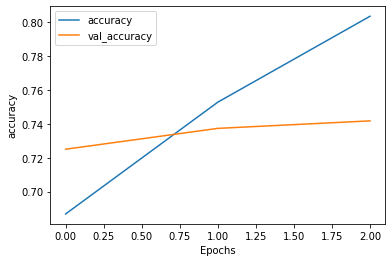

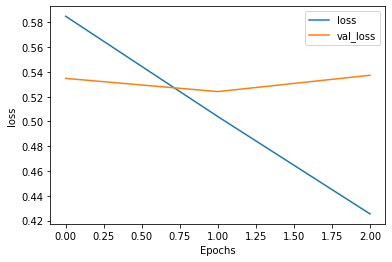

In [32]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")